In [ ]:
!pip install --upgrade --quiet "natural-pdf[ocr-export,ai]"
!pip install --upgrade --quiet easyocr
!pip install --upgrade --quiet surya-ocr

# OCR: Recognizing text

Sometimes you can't actually get the text off of the page. It's an *image* of text instead of being actual text.

CropBox missing from /Page, defaulting to MediaBox


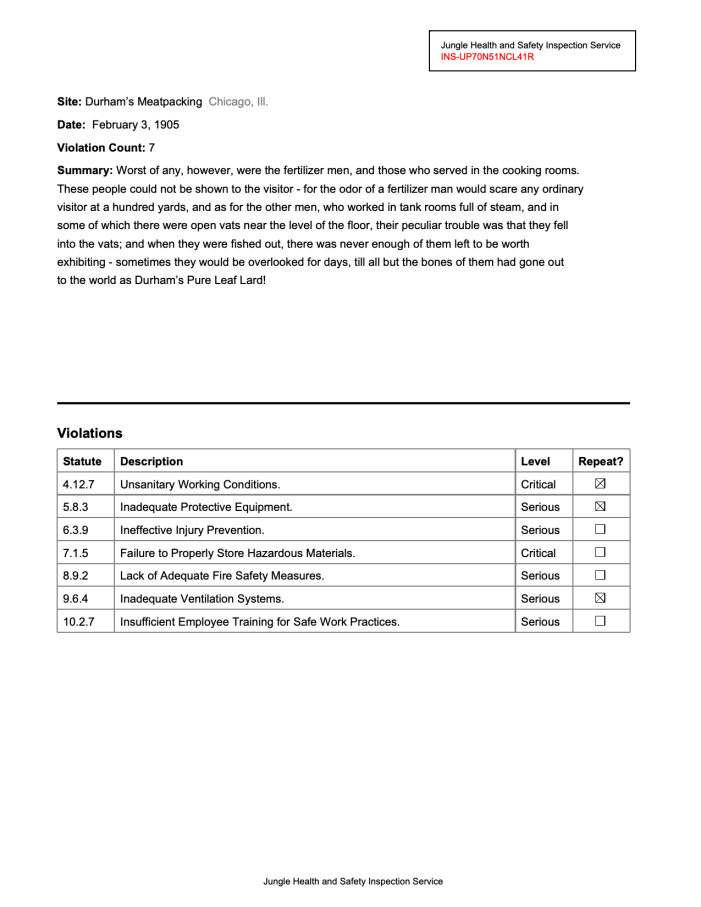

In [80]:
from natural_pdf import PDF

pdf = PDF("https://github.com/jsoma/abraji25-pdfs/raw/refs/heads/main/needs-ocr.pdf")

page = pdf.pages[0]
page.show(width=700)

In [81]:
page.find_all('table')

<ElementCollection[Mixed](count=0)>

In [82]:
page.analyze_layout('yolo')


image 1/1 /var/folders/25/h3prywj14qb0mlkl2s8bxq5m0000gn/T/tmp2b7amvae/temp_layout_image.png: 1024x800 2 titles, 3 plain texts, 2 abandons, 1 table, 813.3ms
Speed: 6.4ms preprocess, 813.3ms inference, 2.5ms postprocess per image at shape (1, 3, 1024, 800)


<ElementCollection[Region](count=8)>

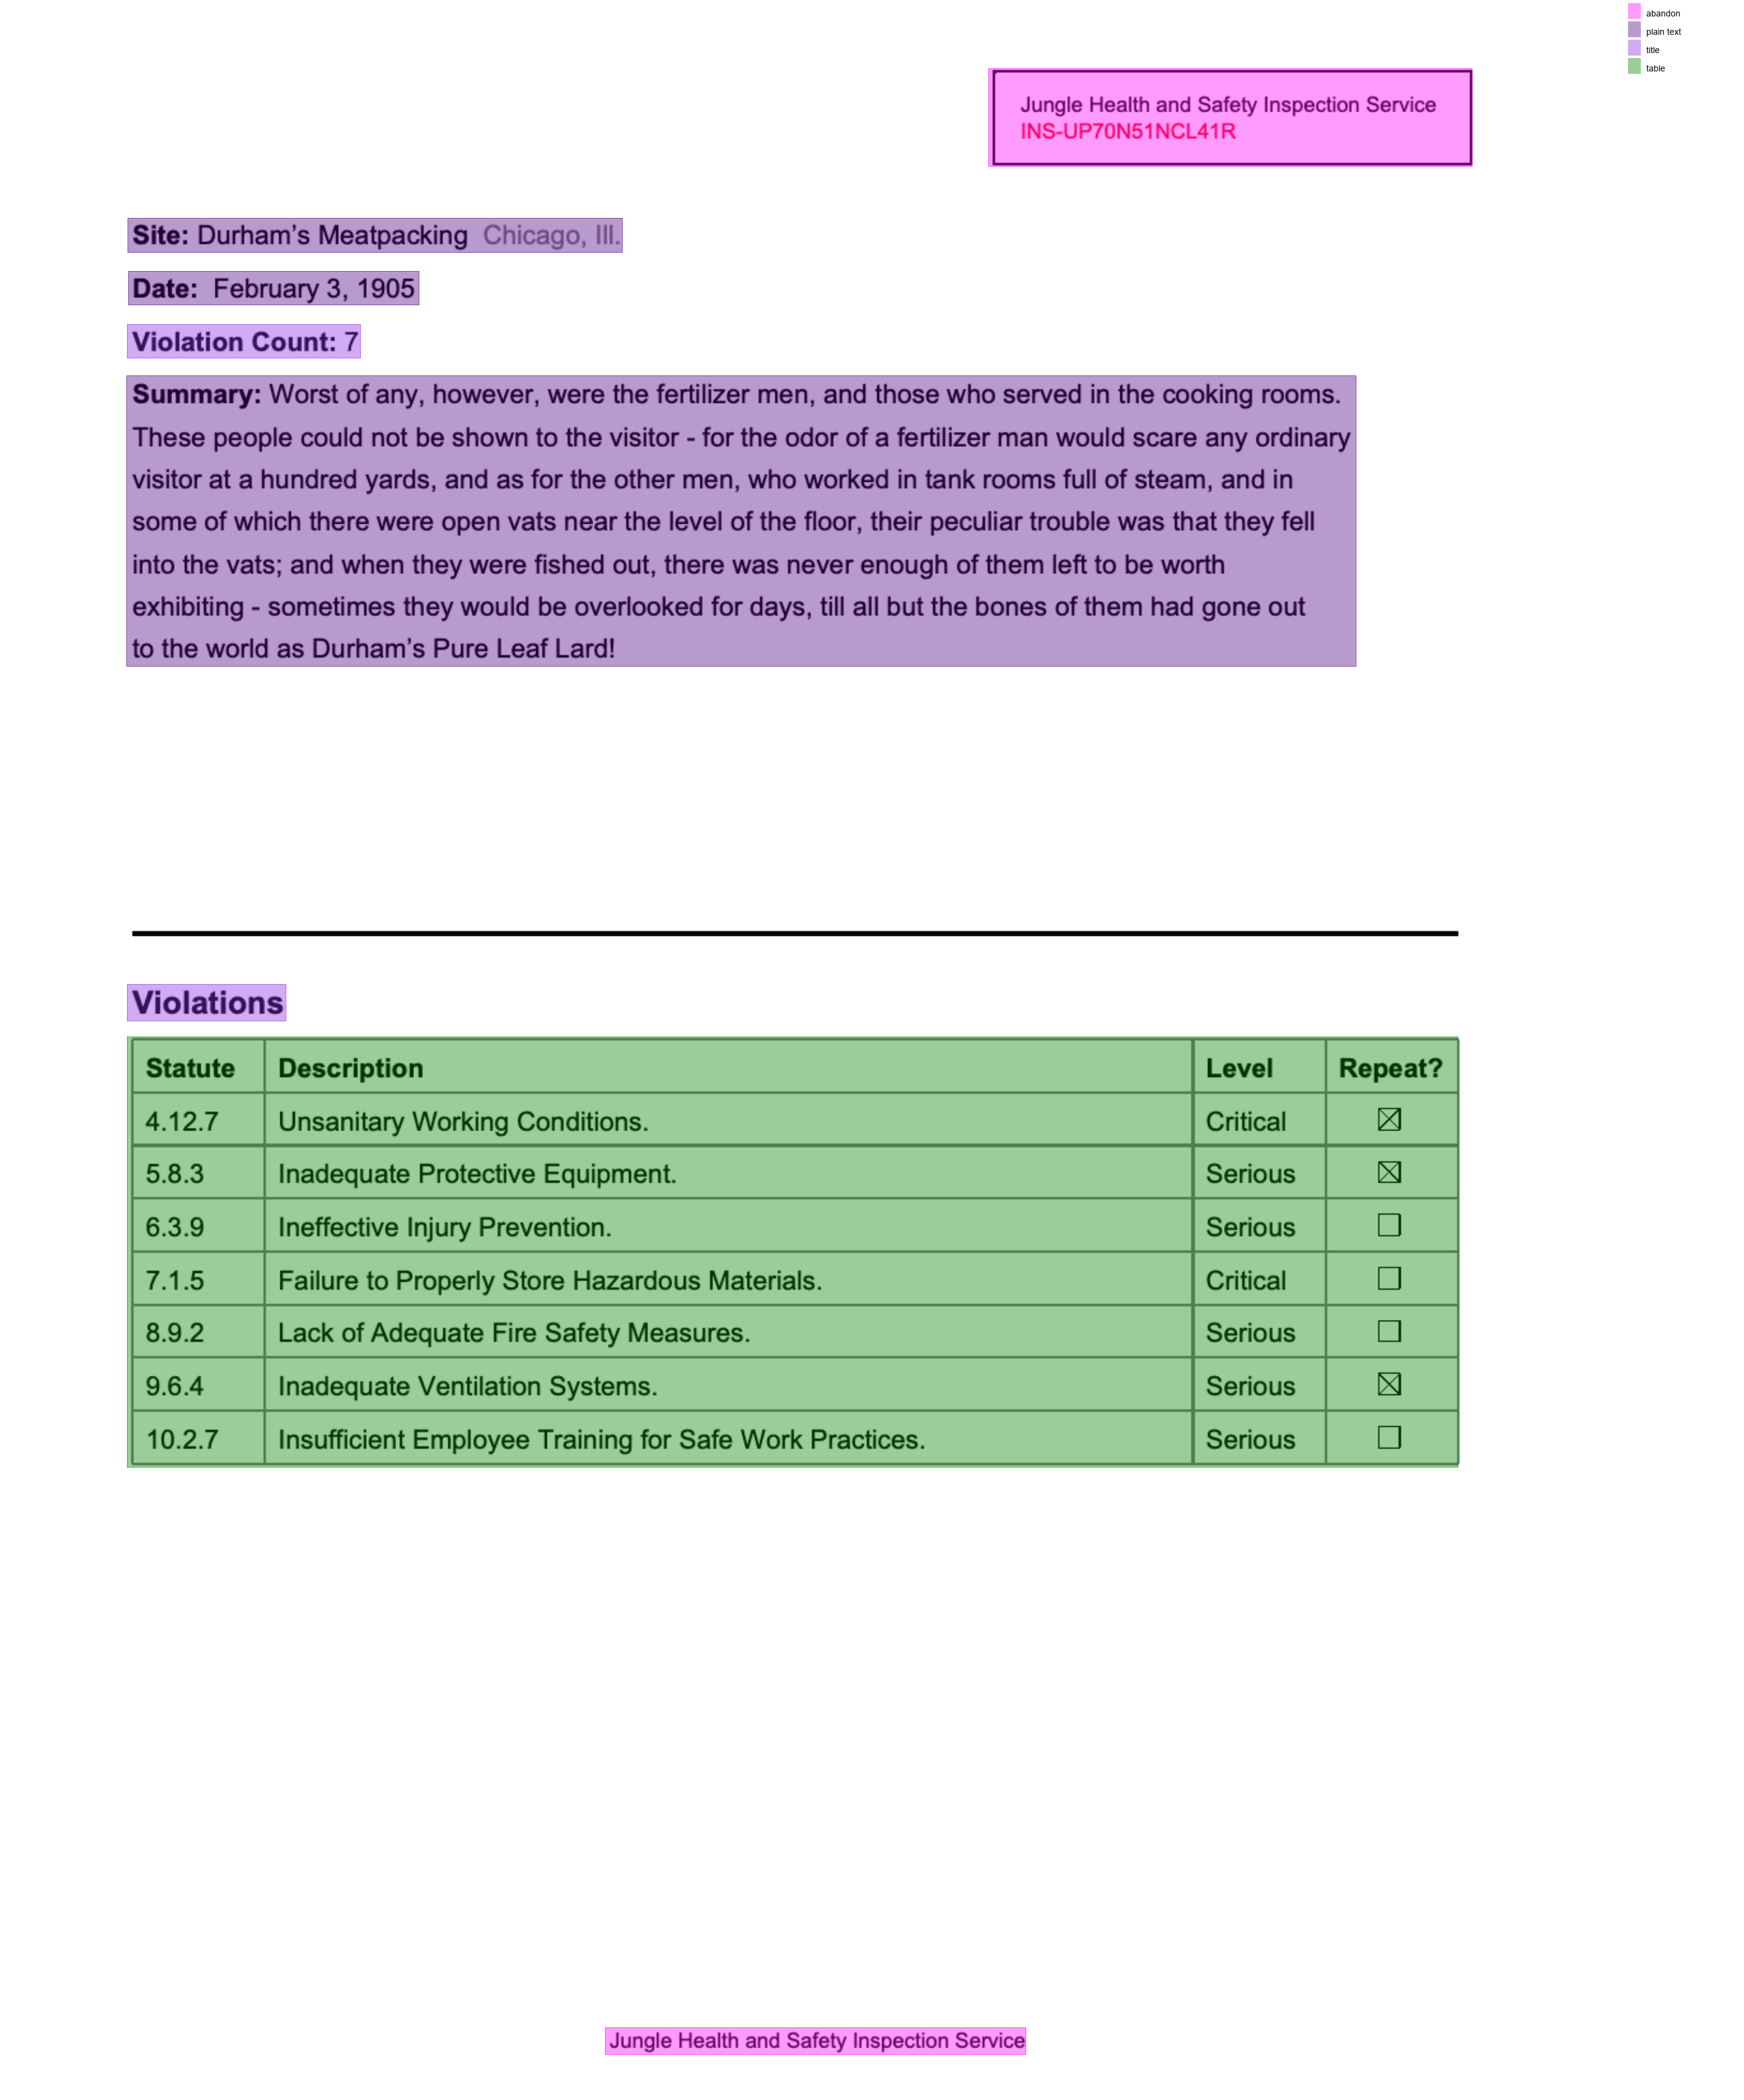

In [83]:
page.find_all('region').show(group_by='type')

Looks the same as the last one, right? But when we try to extract the text...

In [84]:
text = page.extract_text()
print(text)

Nothing! **It's time for OCR.**

There are a looooot of OCR engines out there, and one of the things that makes Natural PDF nice is that it supports multiples. Figuring out which one is the "best" isn't as tough when you can just run them all right after each other.

The default is [EasyOCR](https://github.com/JaidedAI/EasyOCR) which usually works fine.

In [6]:
page.apply_ocr(engine='surya')

Rendering pages:   0%|          | 0/1 [00:00<?, ?it/s]

Recognizing Text: 100%|█████████████████████████| 46/46 [00:25<00:00,  1.79it/s]


<Page number=1 index=0>

In [7]:
text = page.extract_text()
print(text)

Jungle Health and Safety Inspection Service
INS-UP70N51NCL41R
<b>Site: Durham's Meatpacking Chicago, Ill.</b>
Date: February 3, 1905
<b>Violation Count: 7</b>
<b>Summary:</b> Worst of any, however, were the fertilizer men, and those who served in the cooking rooms.
These people could not be shown to the visitor - for the odor of a fertilizer man would scare any ordinary
visitor at a hundred yards, and as for the other men, who worked in tank rooms full of steam, and in
some of which there were open vats near the level of the floor, their peculiar trouble was that they fell
into the vats; and when they were fished out, there was never enough of them left to be worth
exhibiting - sometimes they would be overlooked for days, till all but the bones of them had gone out
to the world as Durham's Pure Leaf Lard!
<b>Violations</b>
<b>Statute</b> <b>Description</b> Level <b>Repeat?</b>
4.12.7 Unsanitary Working Conditions. Critical <math>\boxtimes</math>
5.8.3 Inadequate Protective Equipment. S

I'm very iritated by the "Durham's Pure Leaf Lardl" instead of "Durham's Pure Leaf Lard!". Why'd it miss that??

I don't need to know why, though, really, because I can just try some other engine! You can also fool around with the options - some of the the lowest-hanging fruit is increasing the resolution of the OCR. The default at the moment is 150, you can try upping to 300 for (potentially) better results.

In [5]:
page.apply_ocr('surya', resolution=192)

Rendering pages:   0%|          | 0/1 [00:00<?, ?it/s]

Recognizing Text: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:23<00:00,  1.98it/s]


<Page number=1 index=0>

In [6]:
text = page.extract_text()
print(text)

Jungle Health and Safety Inspection Service
INS-UP70N51NCL41R
Site: Durham's Meatpacking Chicago, Ill.
Date: February 3, 1905
<b>Violation Count: 7</b>
<b>Summary:</b> Worst of any, however, were the fertilizer men, and those who served in the cooking rooms.
These people could not be shown to the visitor - for the odor of a fertilizer man would scare any ordinary
visitor at a hundred yards, and as for the other men, who worked in tank rooms full of steam, and in
some of which there were open vats near the level of the floor, their peculiar trouble was that they fell
exhibiting - sometimes they would be overlooked for days, till all but the bones of them had gone out
to the world as Durham's Pure Leaf Lard!
<b>Violations</b>
<b>Statute</b> <b>Description</b> Level Repeat?
4.12.7 Unsanitary Working Conditions. Critical <math>\boxtimes</math>
5.8.3 Inadequate Protective Equipment. Serious <math>\boxtimes</math>
6.3.9 Ineffective Injury Prevention. Serious <math display="inline">\Box</math

## Finding tables on OCR documents

When we used `page.extract_table()` last time, it was easy because there were all of these `line` elements on the page that pdfplumber could detect and say "hey, it's a table!" For the same reason that there's no *real* text on the page, there's also no *real* lines on the page. Instead, we're going to do a fun secret trick where we look at what horizontal and vertical coordinates *seem* like they might be lines by setting a threshold.

In [9]:
page.extract_table()

TableResult(rows=0)

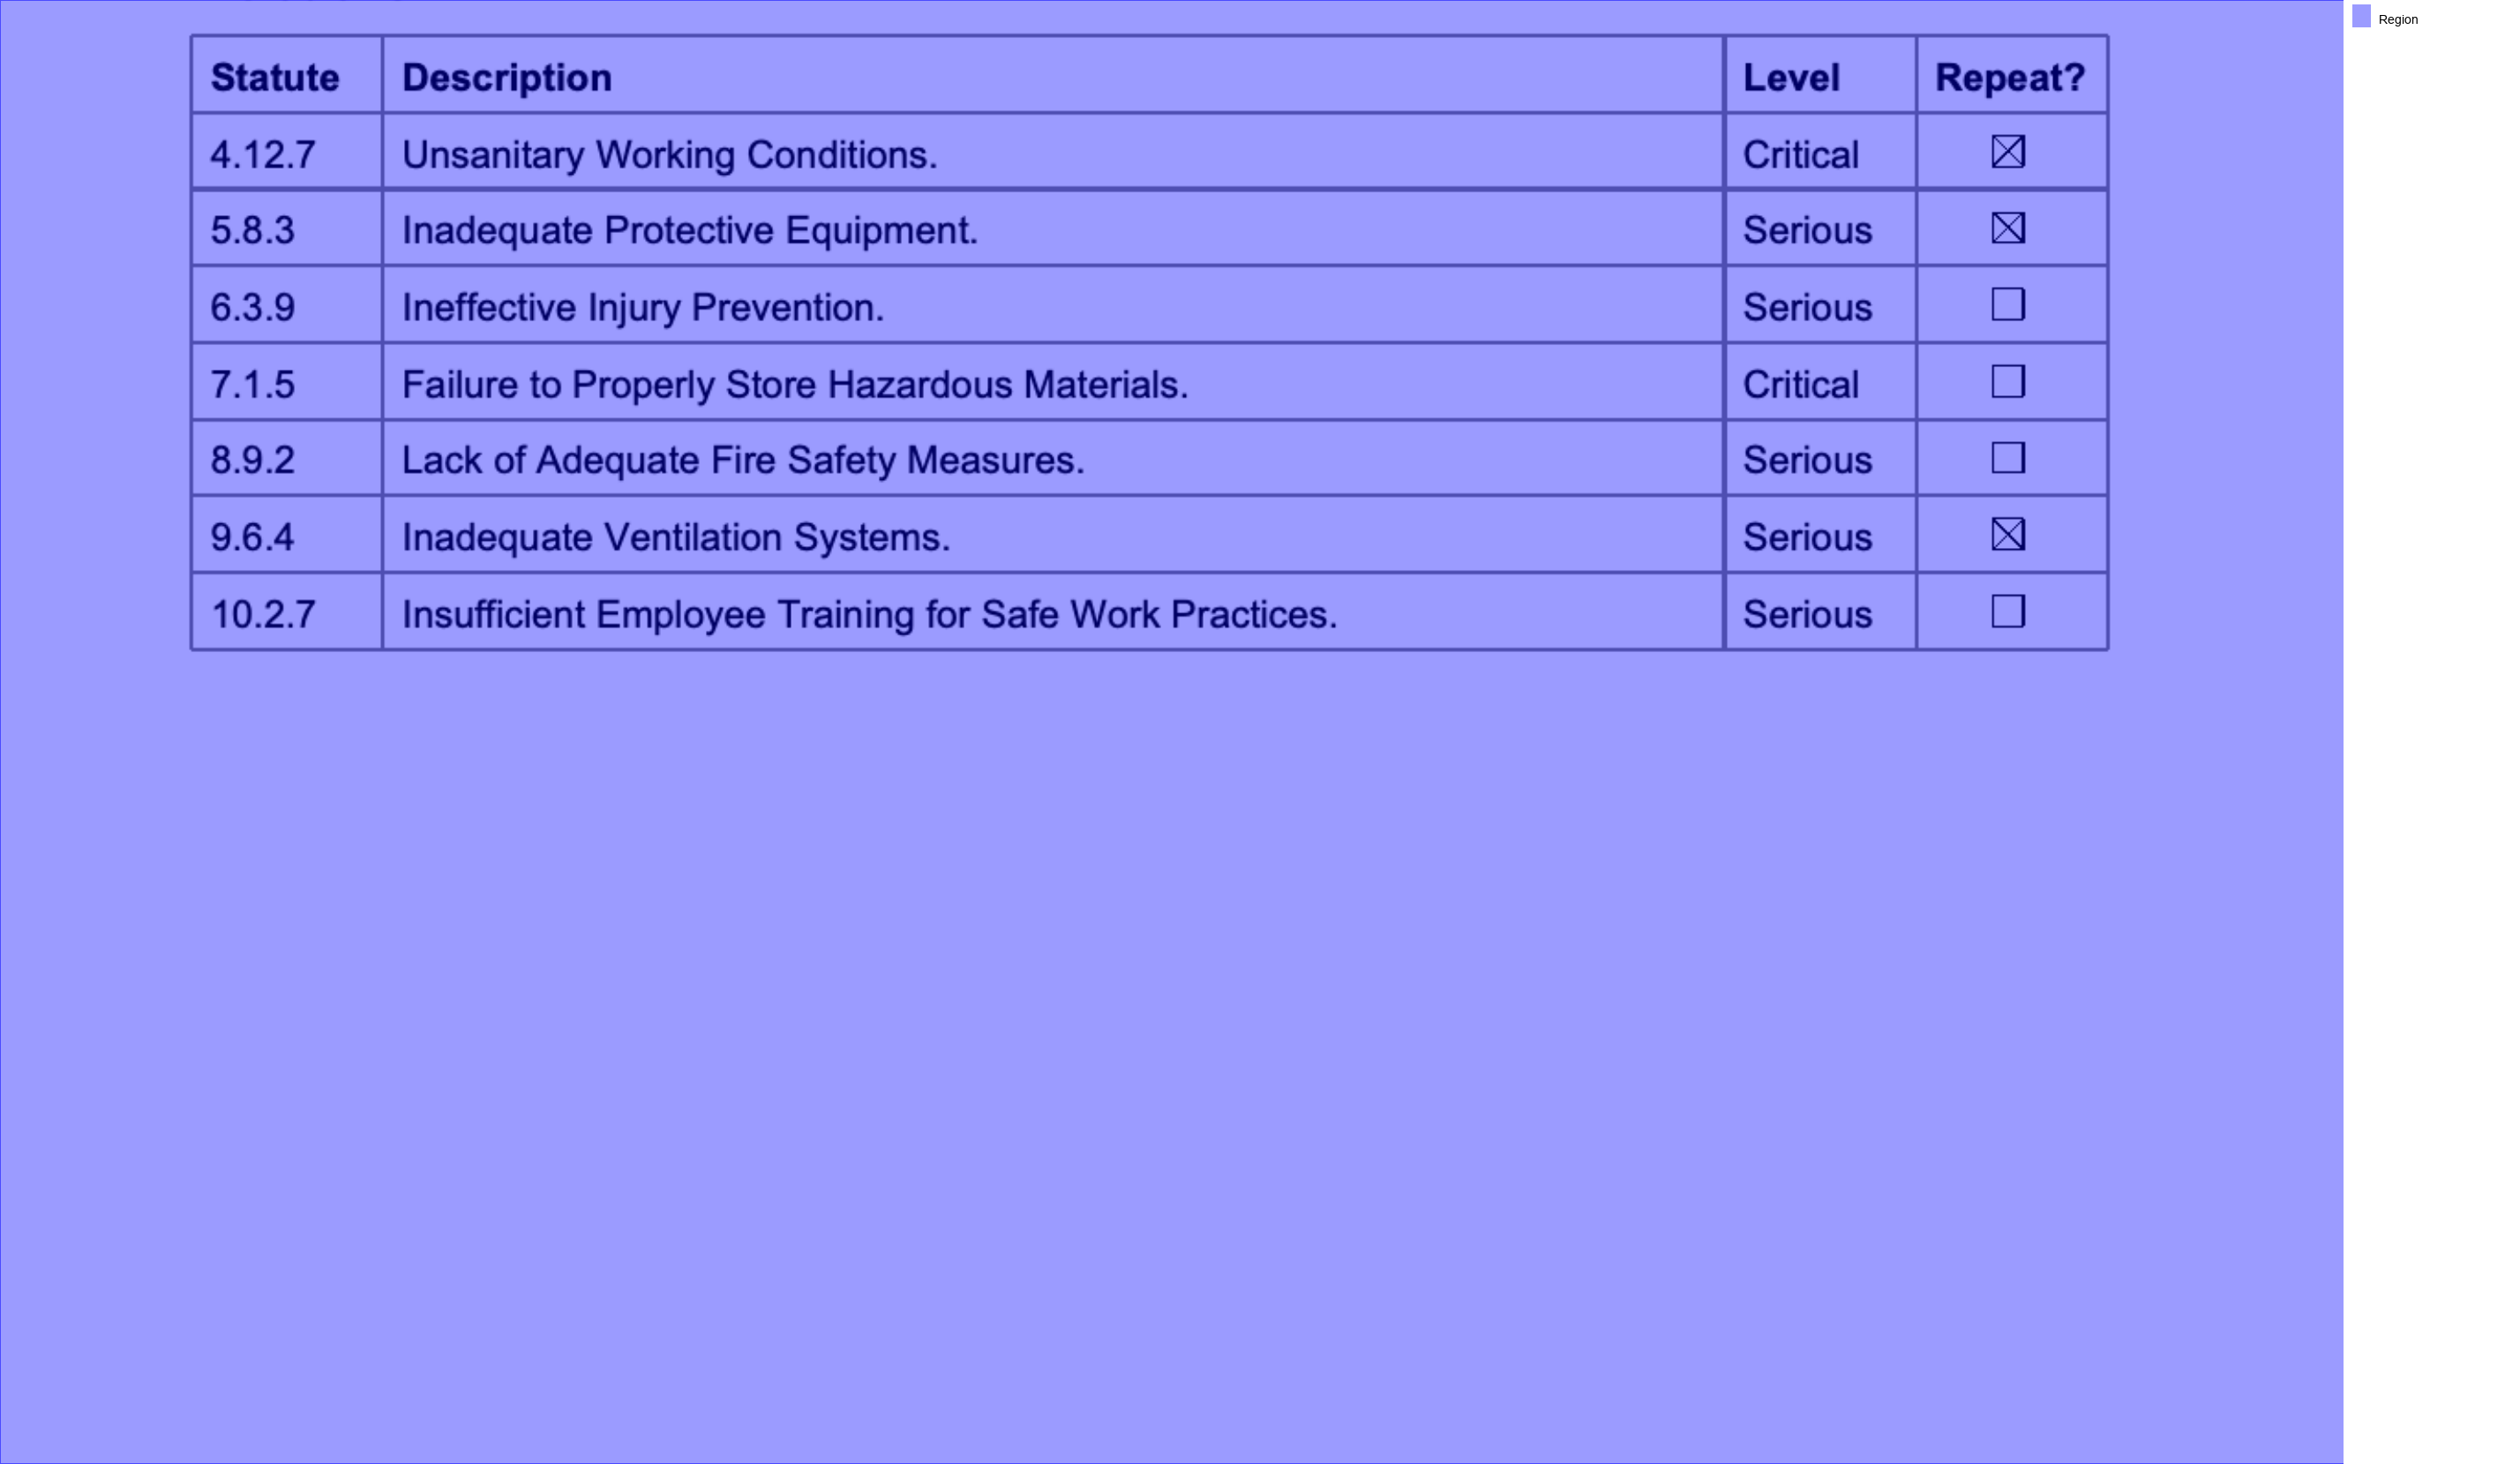

In [10]:
table_area = (
    page
    .find('text:contains(Violations)')
    .below(
        until='text:contains(Jungle)',
        include_endpoint=False
    )
)
table_area.show(crop=True)

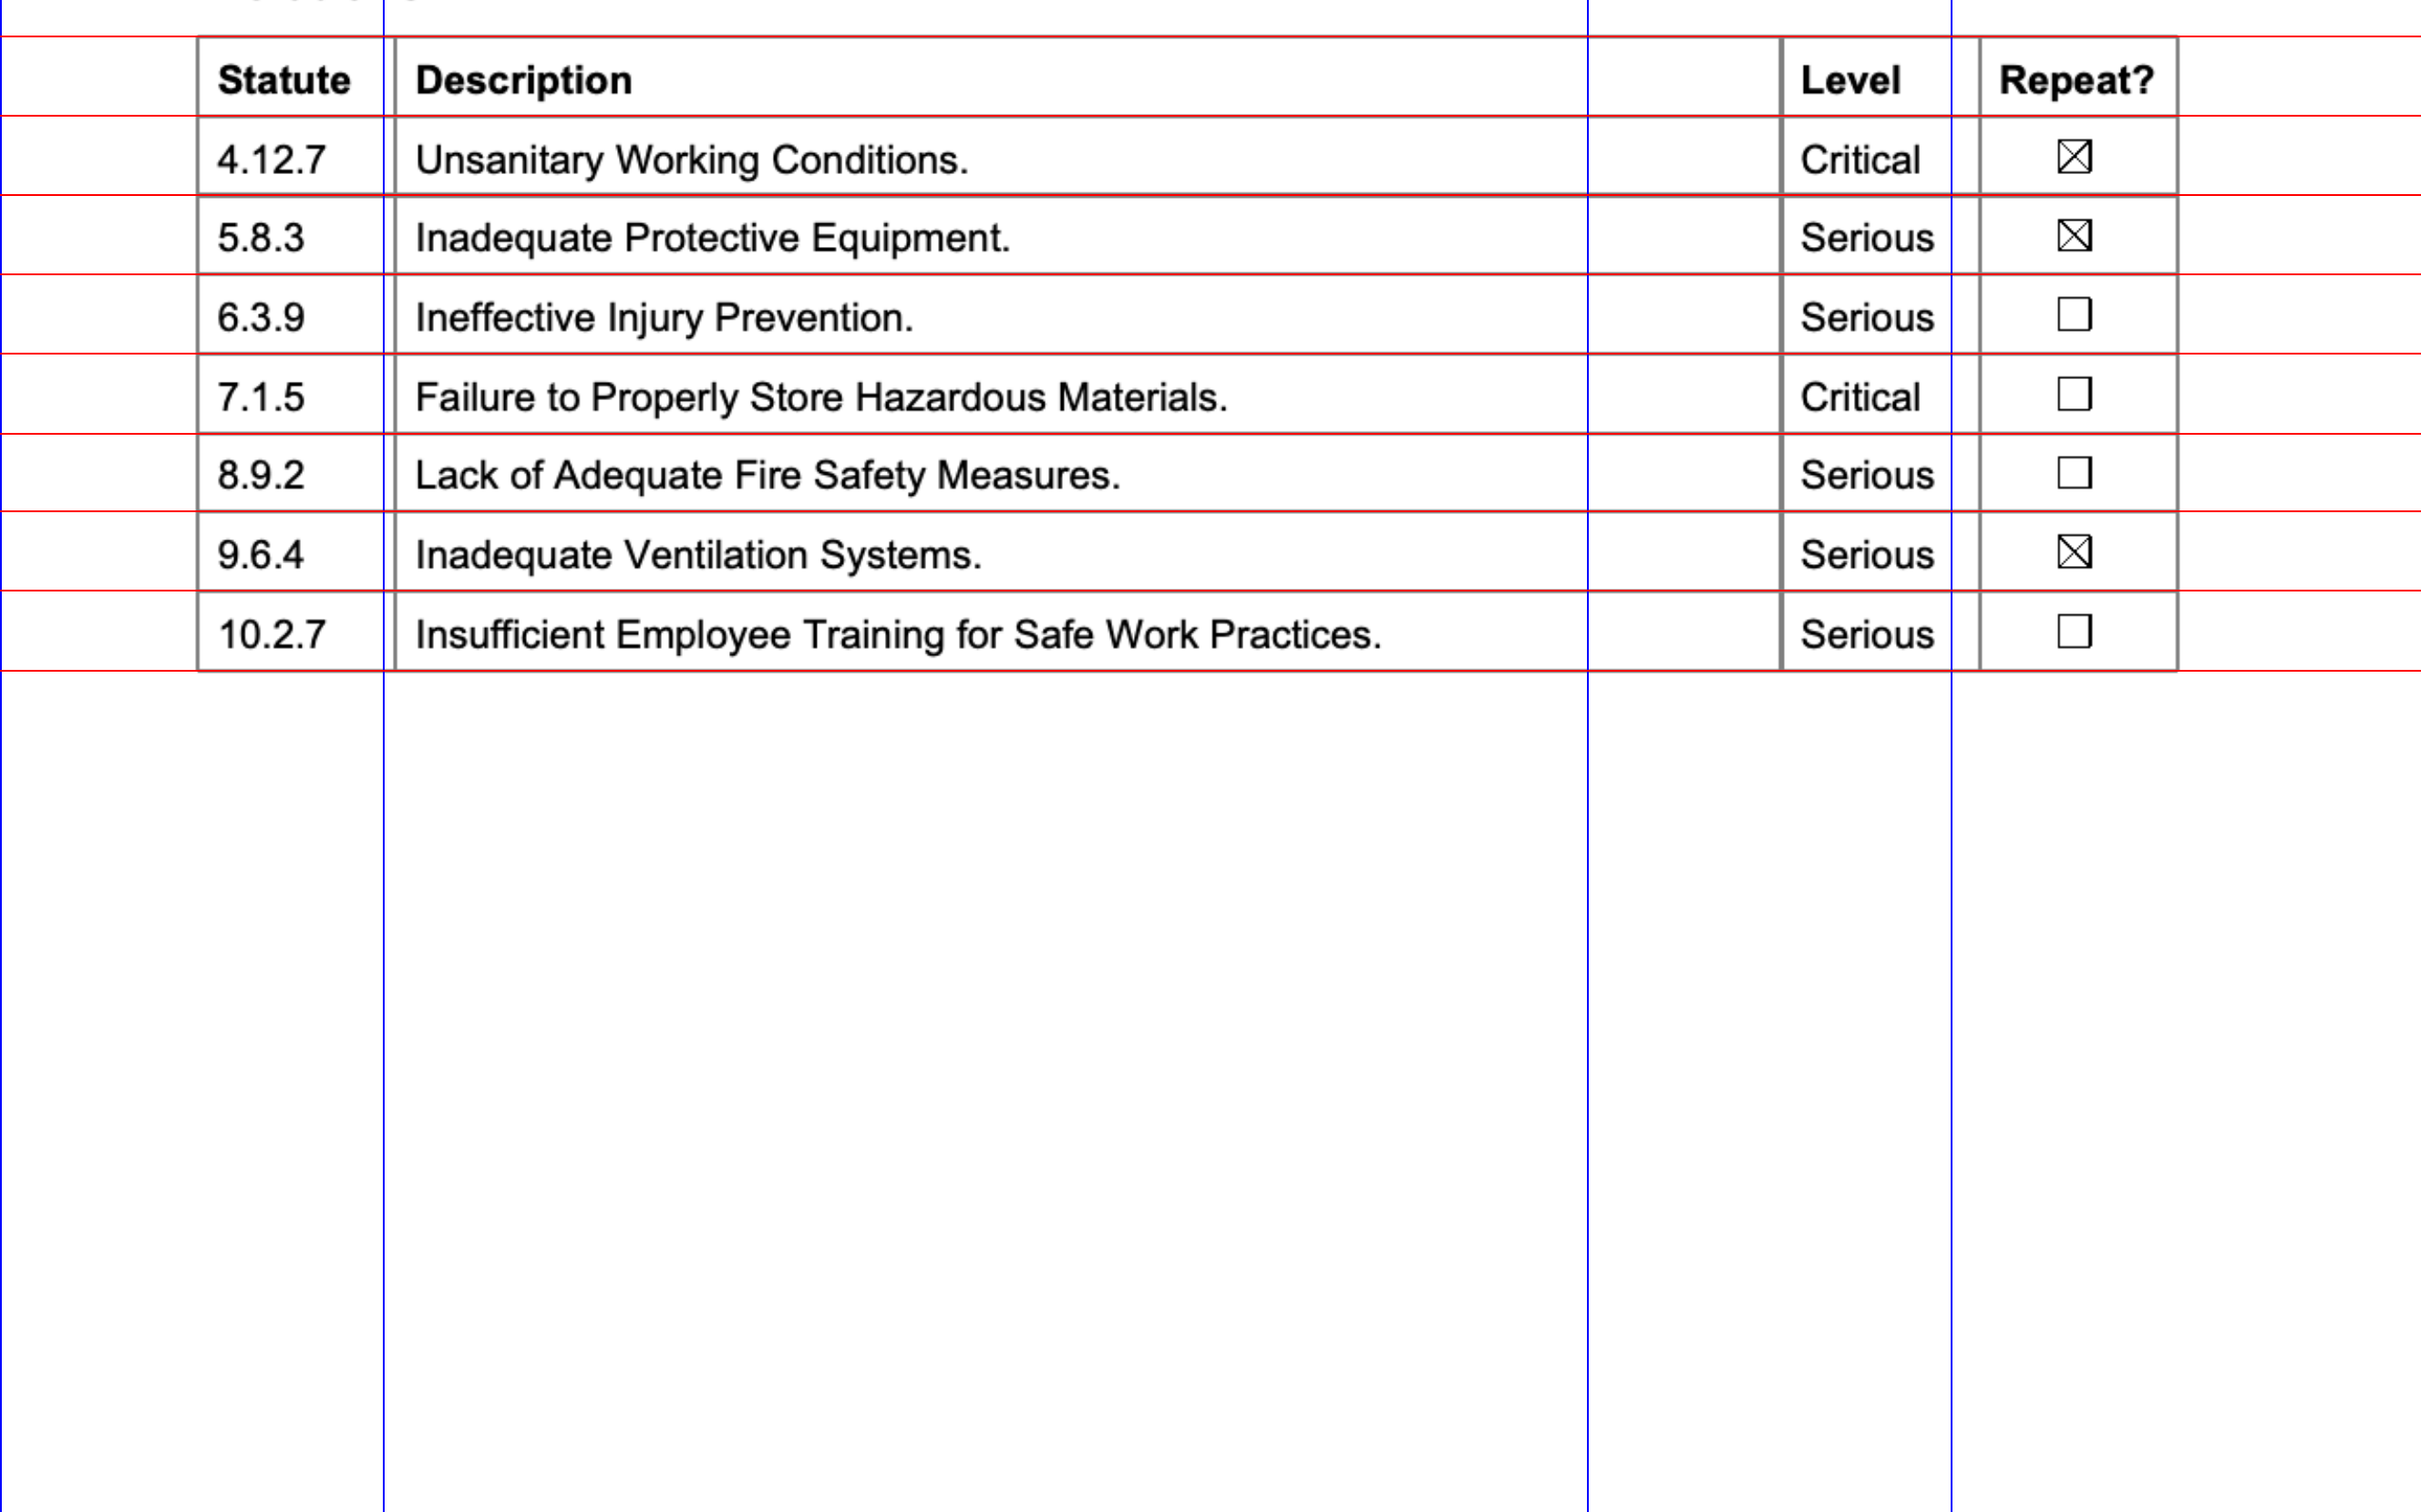

In [20]:
from natural_pdf.analyzers import Guides

guides = Guides(table_area)
# guides.vertical.from_lines(n=5)

guides.vertical.from_content(
    ['Statute', 'Description', 'Level', 'Repeat'],
    align='between'
)
guides.vertical.snap_to_whitespace(detection_method='text')
guides.horizontal.from_lines(threshold=0.8)
guides.show()

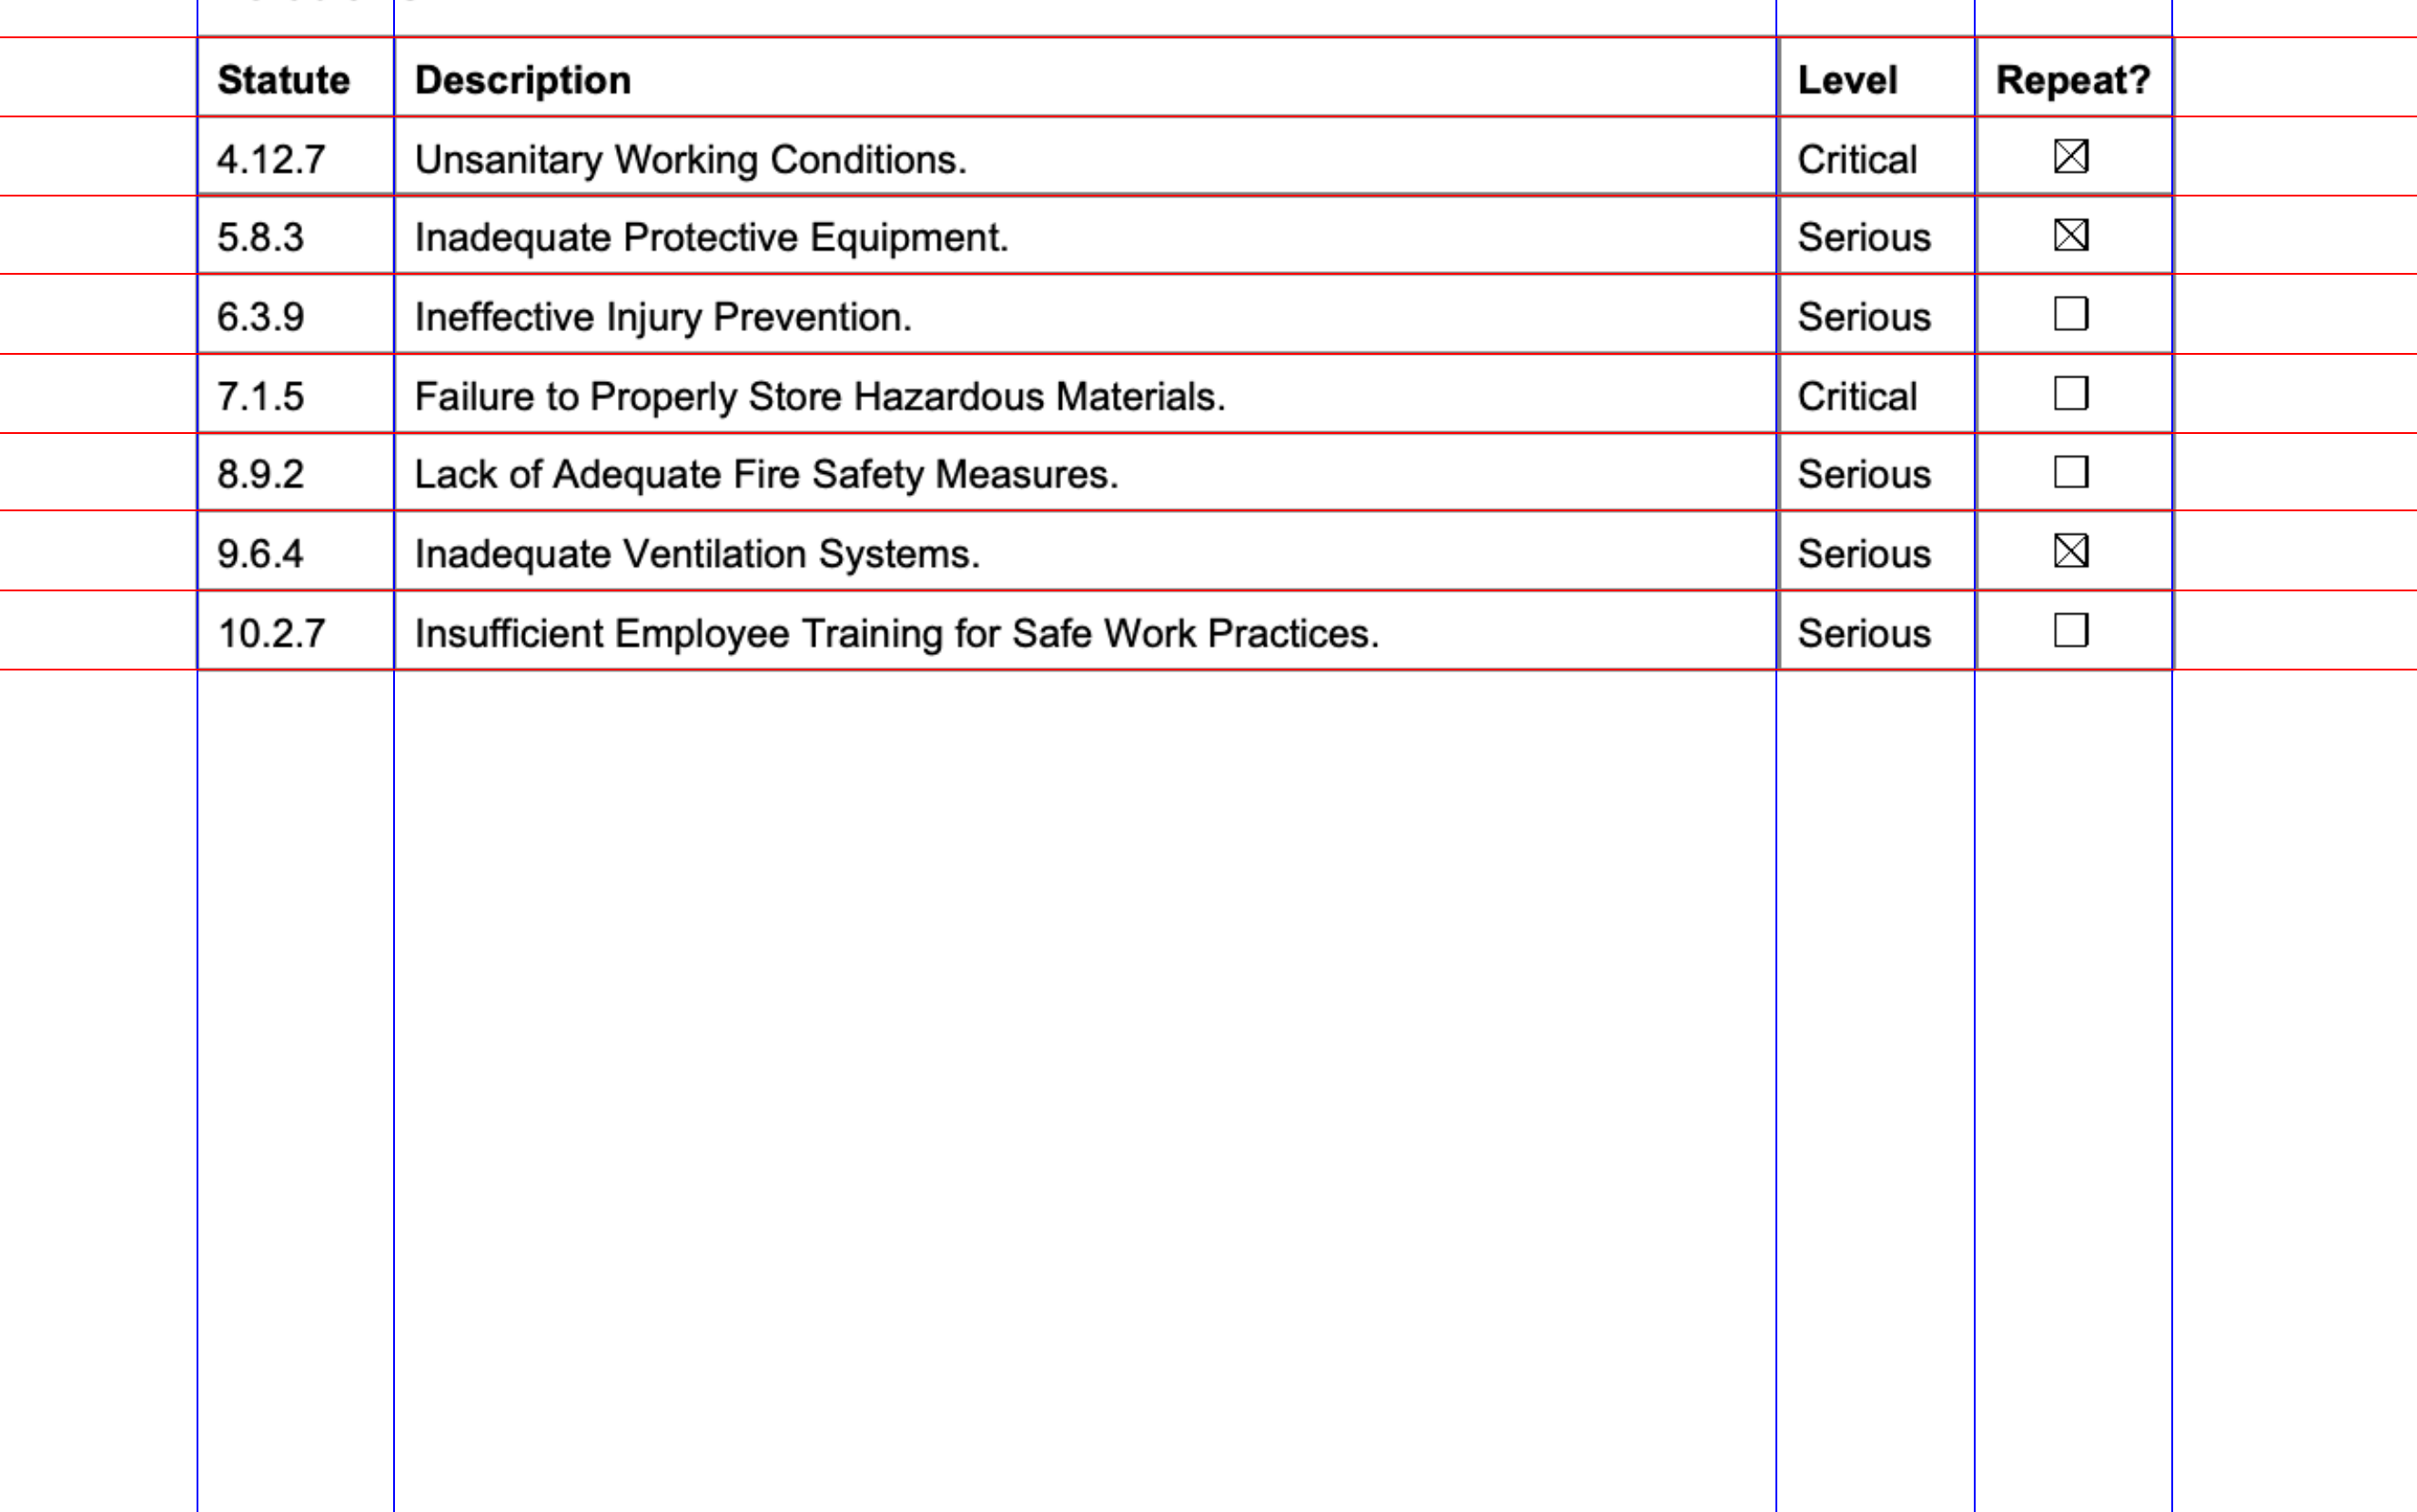

In [20]:
guides.vertical.from_lines(n=5)
guides.show()

In [21]:
guides.build_grid()

{'counts': {'table': 1, 'rows': 8, 'columns': 4, 'cells': 32},
 'regions': {'table': <Region type='table' source='guides' bbox=(0.0, 817.3086502070348, 1275.0, 1151.062488977314)>,
  'rows': [<Region type='table_row' source='guides' bbox=(0.0, 817.3086502070348, 1275.0, 858.9341289750134)>,
   <Region type='table_row' source='guides' bbox=(0.0, 858.9341289750134, 1275.0, 900.5596077429921)>,
   <Region type='table_row' source='guides' bbox=(0.0, 900.5596077429921, 1275.0, 942.1850865109707)>,
   <Region type='table_row' source='guides' bbox=(0.0, 942.1850865109707, 1275.0, 984.1855695921744)>,
   <Region type='table_row' source='guides' bbox=(0.0, 984.1855695921744, 1275.0, 1026.186052673378)>,
   <Region type='table_row' source='guides' bbox=(0.0, 1026.186052673378, 1275.0, 1067.0615228149065)>,
   <Region type='table_row' source='guides' bbox=(0.0, 1067.0615228149065, 1275.0, 1109.0620058961101)>,
   <Region type='table_row' source='guides' bbox=(0.0, 1109.0620058961101, 1275.0, 1151

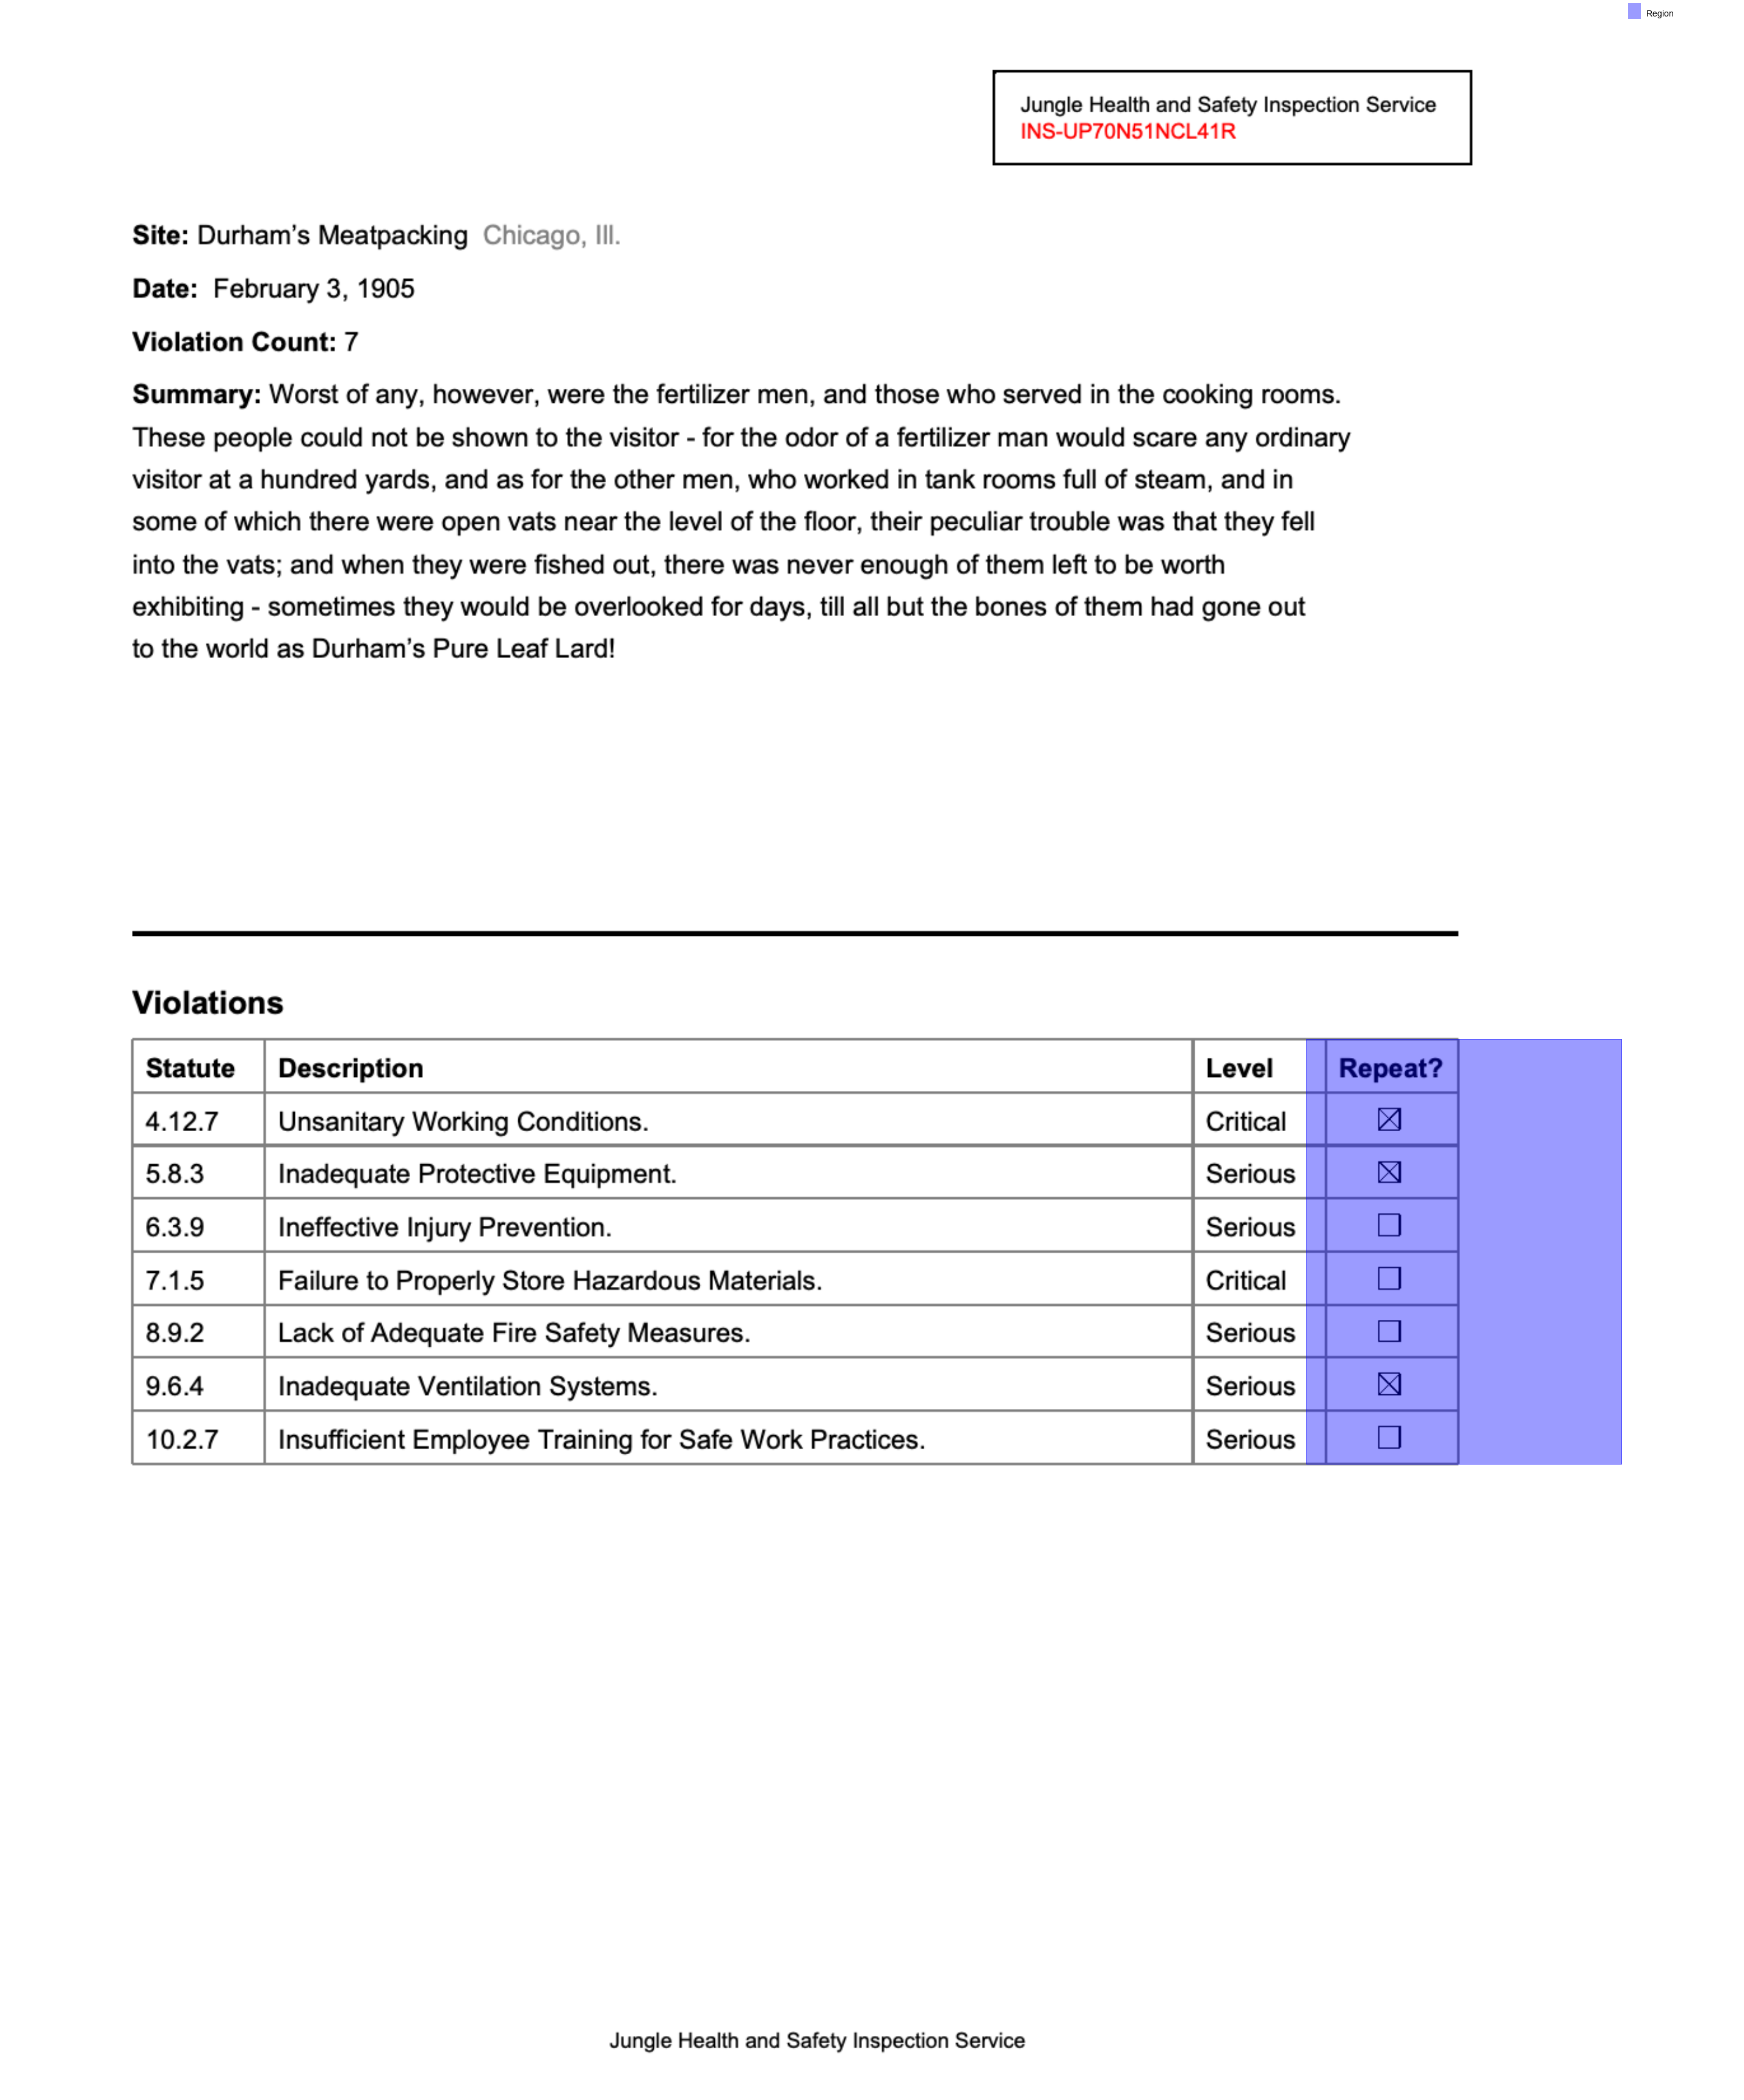

In [24]:
page.find_all('table_column')[-1].show()

In [25]:
df = table_area.find('table').extract_table().to_df()
df

<b>Statute</b>                                 <b>Description</b>     Level  \
0         4.12.7                     Unsanitary Working Conditions.  Critical   
1          5.8.3                   Inadequate Protective Equipment.   Serious   
2          6.3.9                     Ineffective Injury Prevention.   Serious   
3          7.1.5     Failure to Properly Store Hazardous Materials.  Critical   
4          8.9.2             Lack of Adequate Fire Safety Measures.   Serious   
5          9.6.4                    Inadequate Ventilation Systems.   Serious   
6         10.2.7  Insufficient Employee Training for Safe Work P...   Serious   

                       <b>Repeat?</b>  
0              <math>\boxtimes</math>  
1              <math>\boxtimes</math>  
2   <math display="block">\Box</math>  
3  <math display="inline">\Box</math>  
4  <math display="inline">\Box</math>  
5              <math>\boxtimes</math>  
6  <math display="inline">\Box</math>

In [27]:
df.to_csv("output.csv", index=False)

### Figuring out information about things that are *not* text

In a tiny preview of the next notebook: **what about those checkboxes?** Turns out we can use **image classification AI** to do it for us!

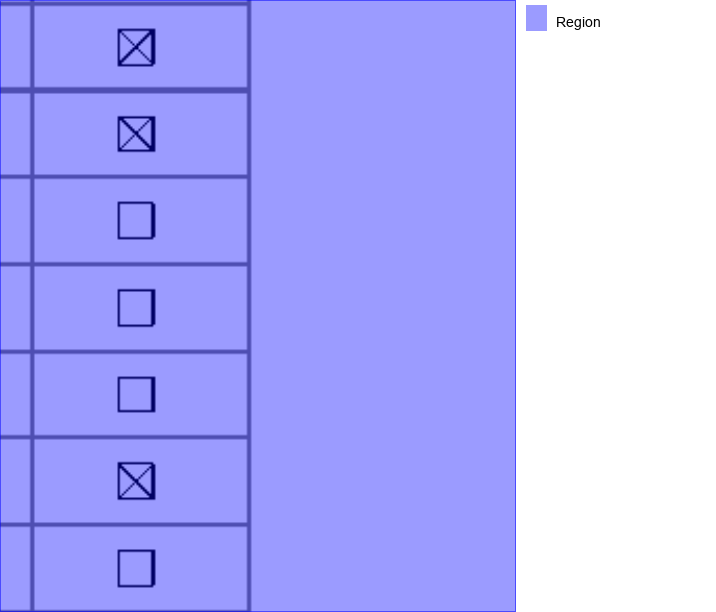

In [29]:
last_col = table_area.find_all('table_column')[-1].expand(top=-40)
last_col.show(crop=True)

In [56]:
cells = last_col.find_all("table_cell")
cells = cells.expand(left=-60, right=-175, top=-16, bottom=-16)
cells.show(crop=True)

In [60]:
cells.classify_all(['X', 'empty'], using='vision')

Classifying batch (openai/clip-vit-base-patch16):   0%|          | 0/7 [00:00<?, ?it/s]

<ElementCollection[Region](count=7)>

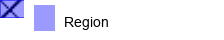

In [61]:
cells[0].show(crop=True)

In [62]:
cells[0].category

'X'

In [72]:
cells[4].category_confidence

0.9350179433822632

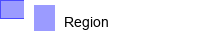

In [65]:
cells[2].show(crop=True)

In [66]:
cells[2].category

'empty'

In [67]:
cells.apply(lambda cell: cell.category)

['X', 'X', 'empty', 'empty', 'empty', 'X', 'empty']

## Correcting OCR

While we love OCR when it works, it often does *not* work great. We have a few solutions: send humans after it, or use LLMs or spell check to correct it.

### With humans

In [28]:
from natural_pdf.utils.packaging import create_correction_task_package
from natural_pdf import PDF
import natural_pdf as npdf
npdf.options.image.width = 500

pdf = npdf.PDF("https://github.com/jsoma/abraji25-pdfs/raw/refs/heads/main/needs-ocr.pdf")

page = pdf.pages[0]
page.apply_ocr()

After we apply OCR we can export to a magic format that we can display and fix up separately!

In [29]:
text = page.extract_text()
print(text)

In [ ]:
Let's ignore this for now.

In [30]:
# create_correction_task_package(pdf, "correction_package.zip", overwrite=True, resolution=300)

### With LLMs

Let's see what our text looks like.

In [ ]:
page.find_all('text').inspect()

Some of these are pretty easy - for example, "Uraanilary Warking Conditions" should be "Unsanity working conditions." OCR tools just don't know that kind of thing! But what if we could go through each piece of text, some some sort of spell check or something?

You can use `correct_ocr` to change the text in a region.

In [ ]:
def correct_text_region(region):
    return "This is the updated text"
    
page.correct_ocr(correct_text_region) 

And then, magically, all of our text is whatever we `return`.

In [ ]:
page.find_all('text').inspect()

But clearly we don't want the same thing every time! Let's add the bad OCR back in...

In [ ]:
# Re-apply the OCR to break it again
page.apply_ocr('surya', resolution=15)

...and feed each line to an LLM trying to fix it.

In [ ]:
from openai import OpenAI
from natural_pdf.ocr.utils import direct_ocr_llm

client = OpenAI(api_key='API_KEY_GOES_HERE')

prompt = """
Correct the spelling of this OCR'd text, a snippet of a document.
Preserve original capitalization, punctuation, and symbols. 
Changing meaning is okay if it's clearly an OCR issue.
Do not add any explanatory text, translations, comments, or quotation marks around the result.
"""

def correct_text_region(region):
    text = region.extract_text()
    completion = client.chat.completions.create(
        model="gpt-4o",
        messages=[
            {
                "role": "system", "content": prompt
            },
            {
                "role": "user",
                "content": text
            },
        ],
    )

    updated = completion.choices[0].message.content

    if text != updated:    
        print(f"OLD: {text}\nNEW:{updated}") 

    return updated

page.correct_ocr(correct_text_region) 

And now we can use `.extract_text()` the magicaly same way.

The real benefit of this vs sending the whole document to the LLM is *we don't change where the text is*. An LLM might OCR something for us, but it *loses the spatial context that we find so important*.

In [ ]:
text = page.extract_text()
print(text)

## Let's do the OCR with the LLM, period

But if the LLM is *that good* at OCR, we can also find pieces of the page we would like to OCR and *send them each in isolation to the LLM*. We use `detect_only=True` so it doesn't try to figure out what the text is, just that the text is there.

In [ ]:
page.apply_ocr('surya', detect_only=True)
page.find_all('text').show()

In [ ]:
page.find_all('text').inspect()

Now we'll do an even fancier `correct_text_region`: it takes the region as an image, and sends it right on over to the LLM for OCR.

In [ ]:
from openai import OpenAI
from natural_pdf.ocr.utils import direct_ocr_llm

client = OpenAI(api_key='API_KEY_GOES_HERE')

prompt = """OCR this image patch. Return only the exact text content visible in the image. 
Preserve original spelling, capitalization, punctuation, and symbols.
Fix misspellings if they are the result of blurry or incorrect OCR.
Do not add any explanatory text, translations, comments, or quotation marks around the result.
If you cannot process the image or do not see any text, return an empty space.
The text is from an inspection report of a slaughterhouse."""
# The text is likely from a Greek document, potentially a spreadsheet, containing Modern Greek words or numbers

def correct_text_region(region):
    # Use a high resolution for the LLM call for best accuracy
    return direct_ocr_llm(
        region, 
        client, 
        prompt=prompt, 
        resolution=150, 
        model="gpt-4o" 
    )

page.correct_ocr(correct_text_region) 

What do we have now?

In [ ]:
page.find_all('text').inspect()

In [ ]:
text = page.extract_text()
print(text)